In [43]:
from tqdm import tqdm
from datasets import load_dataset
import config 

In [2]:


config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_45720/3278871621.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


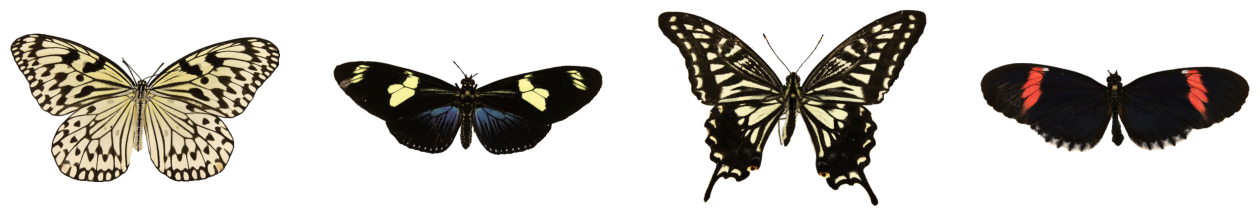

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [4]:
dataset[0]

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'image_alt': 'view Paper Kite digital asset number 1',
 'id': 'ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'name': 'Paper Kite',
 'scientific_name': 'Idea leuconoe',
 'gender': None,
 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae',
 'region': 'US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)',
 'locality': 'NMNH Butterfly Pavilion, North America, United States, District of Columbia',
 'date': None,
 'usnm_no': 'EO401041',
 'guid': 'http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-a33c-611d7b358636',
 'edan_url': 'edanmdm:nmnheducation_11038234',
 'source': 'Smithsonian Education and Outreach collections',
 'stage': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 'image_hash': 'fb0b8749d437efc70a26e54212b3572c',
 'sim_score': 0.8055200576782227}

In [5]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [6]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

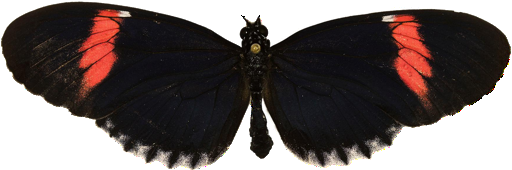

In [8]:
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_45720/2944323820.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


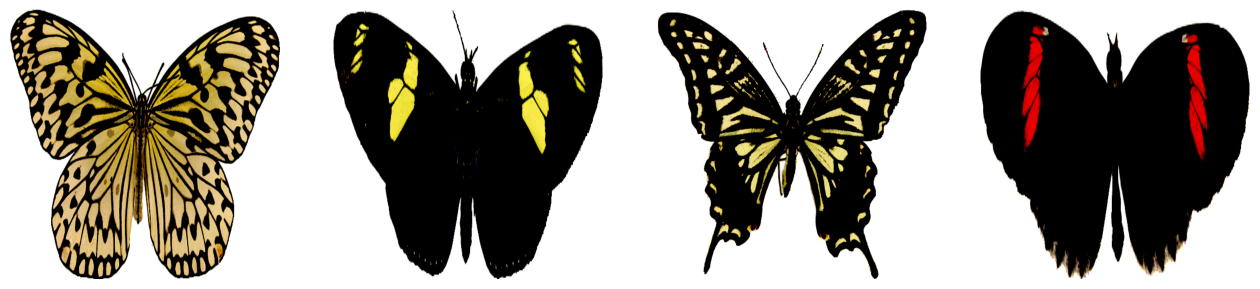

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(range(4)):
    axs[i].imshow(dataset[i]['images'].permute(1,2,0).numpy())
    axs[i].set_axis_off()
fig.show()

In [10]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)

In [13]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [14]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)

Input shape: torch.Size([1, 3, 512, 512])


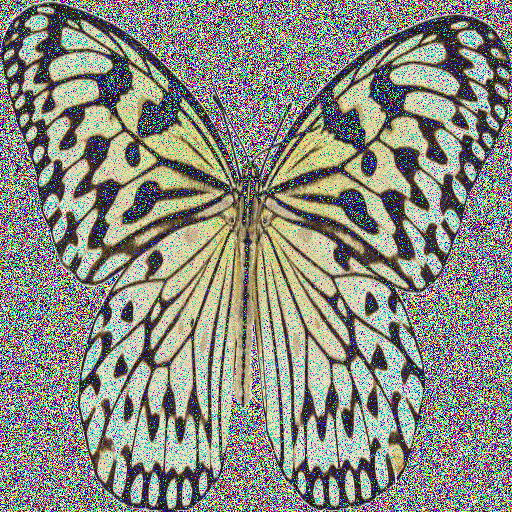

In [23]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [26]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
loss.item()

1.066616177558899

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

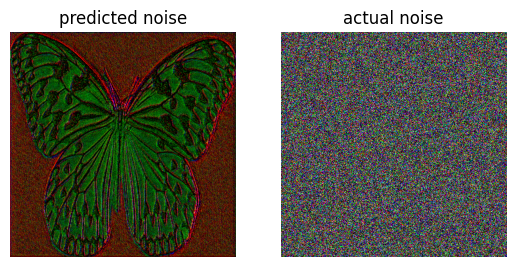

In [36]:
plt.subplot(1,2,1)
plt.imshow(noise_pred.squeeze(0).permute(1,2,0).detach().numpy())
plt.title("predicted noise")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(noise.squeeze(0).permute(1,2,0).detach().numpy())
plt.title("actual noise")
plt.axis("off")


In [38]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader) * config.EPOCHS),
)

In [41]:
from diffusers import DDPMPipeline
import math
import os


def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.EVAL_BATCH_SIZE,
        generator=torch.manual_seed(5),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.OUTPUT_DIR, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [45]:
global_step = 0

# Now you train the model
for epoch in range(config.EPOCHS):
    progress_bar = tqdm(total=len(train_dataloader))
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"]
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.config.NUM_TRAIN_STEPS, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Predict the noise residual
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        loss = F.mse_loss(noise_pred, noise)

        # Normalize loss for gradient accumulation steps
        loss = loss / config.GRADIENT_ACCUMULATION_STEPS
        
        # Backpropagation
        loss.backward()

        # Perform optimizer step only after accumulating enough gradients
        if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0 or (step + 1) == len(train_dataloader):
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            optimizer.step()
            lr_scheduler.step()

            # Zero the gradients
            optimizer.zero_grad()

        # Progress and logging
        progress_bar.update(1)
        logs = {
            "loss": loss.detach().item(),
            "lr": lr_scheduler.get_last_lr()[0],
            "step": global_step
        }
        progress_bar.set_postfix(**logs)

        # Update global step
        global_step += 1

    # After each epoch, optionally sample some demo images with evaluate() and save the model
    pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

    if (epoch + 1) % config.SAVE_IMAGE_EPOCHS == 0 or epoch == config.EPOCHS - 1:
        evaluate(config, epoch, pipeline)

    if (epoch + 1) % config.SAVE_MODEL_EPOCHS == 0 or epoch == config.EPOCHS - 1:
        pipeline.save_pretrained(config.OUTPUT_DIR)

Epoch 0:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 